<a href="https://colab.research.google.com/github/lqiang67/generative_models_examples/blob/main/rectified_flow_2D_toy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

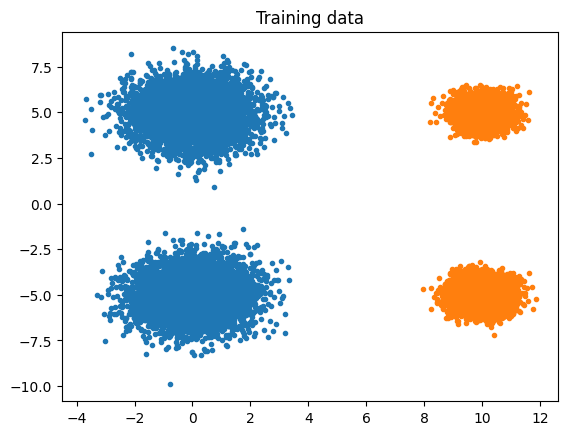

In [17]:
import torch.distributions as dist
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader

# Data
n_samples = 1000
dim_x = 2
dim_z = 1

# Parameters for the Gaussian Mixture Model
n_components = 2 # Number of components in the mixture
n_features = dim_x   # Number of features (dimensions)
n_samples = 10000  # Number of samples to draw

#pi0
#means = 0*torch.randn(n_components, n_features);
means = torch.tensor([[0.0, 5.0], [0.0, -5.0]]) * 1
stds = torch.ones(n_components, n_features)
weights = torch.ones(n_components); weights /= weights.sum()
pi0 = dist.MixtureSameFamily(dist.Categorical(weights), dist.Independent(dist.Normal(means, stds), 1))

#pi1
means = torch.tensor([[5.0, 5.0], [5.0, -5.0]])
#torch.randn(n_components, n_features);
#stds = torch.rand(n_components, n_features)
stds = torch.ones(n_components, n_features)/2
means[:,0] = means[:,0] + 5
weights = torch.rand(n_components); weights /= weights.sum()
pi1 = dist.MixtureSameFamily(dist.Categorical(weights), dist.Independent(dist.Normal(means, stds), 1))

D1 = pi1.sample([n_samples])
D0 = pi0.sample([n_samples])

plt.figure()
plt.plot(D0[:,0], D0[:,1], '.', label='D0')
plt.plot(D1[:,0], D1[:,1], '.', label='D1')
plt.title('Training data');


In [18]:
#@title Euler sampler
from collections import namedtuple

def euler_sampler(model, x0, y=None, num_steps=100, record_traj_period = 1):

  xt = x0.clone()
  xtraj = [xt]
  x1_pred_traj = []

  record_idx = torch.unique(torch.cat([torch.tensor([0]), torch.arange(0, num_steps-1, record_traj_period), torch.tensor([num_steps])]))
  with torch.no_grad():
    for step in range(num_steps):

      t = (step / num_steps); step_size = 1/num_steps
      t_ones = t*torch.ones(xt.shape[0],1).to(x0.device)


      v_t = model(xt, t_ones.squeeze())

      x1_pred = xt + (1-t) * v_t;

      xt = xt + step_size *  v_t

      if step in record_idx:
        x1_pred_traj.append(x1_pred); xtraj.append(xt)

    xtraj = torch.stack(xtraj); x1_pred_traj = torch.stack(x1_pred_traj)
  Results = namedtuple('Results', ['xt', 'xtraj', 'x1_pred_traj'])
  return  Results(xt, xtraj, x1_pred_traj)


In [23]:
#@title Training Rectified Flow
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

# a general MLP which can use customed linear layers and activation functions.
class MLP(nn.Module):
    def __init__(self, layer_sizes, activation=nn.ReLU, linear_layer=nn.Linear):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        self.activation = activation
        self.linear_layer = linear_layer
        for i in range(len(layer_sizes) - 1):
            self.layers.append(self.linear_layer(layer_sizes[i], layer_sizes[i + 1]))
            if i < len(layer_sizes) - 2:  # No activation after the last layer
                self.layers.append(self.activation())

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        for layer in self.layers:
            x = layer(x)
        return x


# a model for velocity field v(x,t)
class Model(nn.Module):
  def __init__(self, dim, hidden_sizes=[128, 128, 128]):
    super().__init__()
    self.mlp = MLP([dim+1, *hidden_sizes, dim])
  def forward(self, x, t):
    x = x.view(x.shape[0], -1)
    t = t.view(t.shape[0], -1)
    xt = torch.cat((x, t), dim=1)
    return self.mlp(xt)

# training loop
def training_rectified_flow(D0, D1, model, optimizer,  num_iterations =1000,  batch_size = 64):
  loss_curve = []
  for i in range(num_iterations):

    optimizer.zero_grad()

    X1 = D1[torch.randperm(len(D1))[:batch_size]]
    X0 = D0[torch.randperm(len(D0))[:batch_size]]
    #X0 = torch.randn_like(X1).to(X1.device)

    # sample time
    t = torch.rand((batch_size,1)).to(X1.device)

    # get training pairs
    Xt = t * X1 + (1-t) * X0
    dot_Xt = X1 - X0

    # MSE loss
    loss = torch.mean((model(Xt, t) - dot_Xt)**2)

    loss.backward()
    optimizer.step()

    loss_curve.append(loss.item())

  return loss_curve


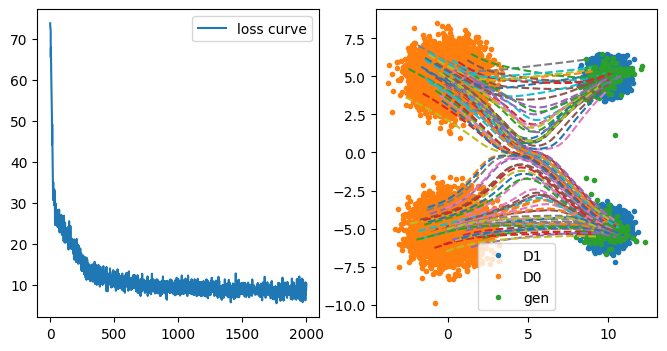

In [25]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

dim = D1.shape[1]
model = Model(dim).to(device)
D1 = D1.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005)

loss_curve = training_rectified_flow(D0, D1, model, optimizer, num_iterations=2000, batch_size =256)
x0 = pi0.sample([1000]).to(device)
result = euler_sampler(model, x0, num_steps=100)


def plot_result(result, loss_curve, D0, D1):
  xt = result.xt
  xtraj = result.xtraj.cpu()
  plt.figure(figsize=(4*2,4));
  plt.subplot(121)
  plt.plot(loss_curve, label='loss curve')
  plt.legend()
  plt.subplot(122)
  plt.plot(D1[:,0], D1[:,1], '.', label='D1');
  plt.plot(D0[:,0], D0[:,1], '.', label='D0');
  plt.plot(xtraj[-1][:,0], xtraj[-1][:,1], '.', label='gen',alpha = 1);
  plt.plot(xtraj[:, :100,0], xtraj[:,:100, 1], '--', alpha = 1);
  plt.legend();
  plt.show()

plot_result(result,loss_curve, D0, D1)
